In [1]:
import os
import re

from dotenv import find_dotenv, load_dotenv
from IPython.display import display, Image
from rich import print as rprint
from rich.markdown import Markdown
from rich.pretty import Pretty
from rich.text import Text

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
LANGCHAIN_API_KEY = os.getenv('LANGCHAIN_API_KEY')
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = LANGCHAIN_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

In [3]:
from langchain_community.chat_models import ChatOllama
from langchain_community.embeddings import OllamaEmbeddings

# LLM cho chat
llm = ChatOllama(
    model="gemma3:1b",
    base_url="http://localhost:11434"
)

# Embedding model
embedding = OllamaEmbeddings(
    model="embeddinggemma:300m",
    base_url="http://localhost:11434"
)

c:\Users\xgear\miniconda3\envs\intern\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\xgear\AppData\Local\Temp\ipykernel_9944\3321198127.py:5: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the `langchain-ollama package and should be used instead. To use it run `pip install -U `langchain-ollama` and import as `from `langchain_ollama import ChatOllama``.
  llm = ChatOllama(
C:\Users\xgear\AppData\Local\Temp\ipykernel_9944\3321198127.py:11: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the `langchain-ollama package and should be used instead. To use it run `pip install -U `langchain

In [4]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
articles = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

loader = WebBaseLoader(
    web_paths=articles,
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
len(docs)

3

In [6]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
splits = text_splitter.split_documents(docs)
len(splits)

174

In [7]:
from langchain_core.vectorstores import InMemoryVectorStore

vectorstore = InMemoryVectorStore(embedding)
doc_ids = vectorstore.add_documents(documents=splits)
len(doc_ids), len(vectorstore.store)

retriever = vectorstore.as_retriever()

# RAG

In [ ]:
from typing import Annotated, Literal, TypedDict

import json
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langchain_core.runnables import chain
from langgraph.graph import END, START, StateGraph
from langgraph.types import Command
from pydantic import BaseModel, Field


In [9]:
retrieval_prompt_template = """You are grader assistant assessing the need to retrieve additional documents to answer the user's question.
If you are sure that all the necessary data is available, then you do not need to retrieve additional documents.
Give a binary score to indicate whether retrieval is required.

User question:
{question}
"""
rag_prompt_template = """Answer the following question based on this context:

{context}

Question: {question}
"""
answer_prompt_template = """Answer the following question:

Question: {question}
"""
no_answer_prompt = "I don't have an answer to the question."
relevance_grading_prompt_template = """You are a grader assessing relevance of a retrieved document to a user question.
It does not need to be a stringent test. The goal is to filter out erroneous retrievals.
If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant.
Give a binary score to indicate whether the document is relevant to the question.

Retrieved document:
{document}

User question:
{question}
"""
hallucinations_grading_prompt_template = """You are a grader assessing whether an LLM answer is grounded in / supported by a set of retrieved facts.
Give a binary score whether the answer is grounded in / supported by the set of facts.

Set of facts:
{context}

LLM answer:
{answer}
"""
answer_grading_prompt_template = """You are a grader assessing whether an answer addresses / resolves a question. 
Give a binary score whether the answer resolves the question.

User question:
{question}

LLM answer:
{answer}
"""
query_rewriting_prompt_template = """You a question re-writer that converts an input question to a better version that is optimized for web search. 
Look at the input and try to reason about the underlying semantic intent / meaning.

Here is the initial question:
{question}

Formulate an improved question."""

In [15]:
class RetrievalGrade(BaseModel):
    chain_of_thought: str = Field(description="Reasoning")
    is_required: bool = Field(description="Is retrieval required")

class RelevanceGrade(BaseModel):
    chain_of_thought: str = Field(description="Reasoning")
    is_relevant: bool = Field(description="Is document relevant")

class HallucationsGrade(BaseModel):
    chain_of_thought: str = Field(description="Reasoning")
    is_grounded: bool = Field(description="Is answer grounded")

class AnswerGrade(BaseModel):
    chain_of_thought: str = Field(description="Reasoning")
    is_useful: bool = Field(description="Is answer useful")

In [16]:
def format_docs(docs: list[Document]) -> list[str]:
    return "\n\n".join(doc.page_content for doc in docs)

In [17]:
class State(TypedDict):
    question: str
    retrieval_grade: RetrievalGrade
    documents: list[Document]
    relevance_grades: list[RelevanceGrade]
    generation: str
    hallucinations_grade: HallucationsGrade
    context: list[Document]
    answer_grade: AnswerGrade
    answer: str

In [18]:
@chain
def grade_document_relevance(document, question):
    doc_content = document.page_content if hasattr(document, "page_content") else str(document)
    
    prompt = f"""You are a strict relevance grader. 
    Return a JSON object with keys "chain_of_thought" and "is_relevant" (bool).
    DOCUMENT: {doc_content}
    QUESTION: {question}"""
    
    response = llm.invoke(prompt)
    
    content = response.content.replace("```json", "").replace("```", "").strip()
    return RelevanceGrade(**json.loads(content))

In [ ]:
def grade_retrieval(state: State):
    question = state["question"]
    prompt = f"""You are a grader assessing if retrieval is required.
    Return a JSON object with keys "chain_of_thought" and "is_required" (bool).
    QUESTION: {question}"""
    response = llm.invoke(prompt)
    content = response.content.replace("```json", "").replace("```", "").strip()
    grade = RetrievalGrade(**json.loads(content))
    return {"retrieval_grade": grade}


def decide_to_retrieve(state: State) -> Literal["retrieve", "generate_answer"]:
    if state["retrieval_grade"].is_required:
        return "retrieve"
    return "generate_answer"


def retrieve(state: State):
    return {"documents": retriever.invoke(state["question"])}


def grade_documents(state: State):
    question = state["question"]
    documents = state["documents"]

    relevance_grades = grade_document_relevance.batch(documents, question=question)
    filtered_documents = [
        doc for doc, grade in zip(documents, relevance_grades) if grade.is_relevant
    ]
    return {"context": filtered_documents, "relevance_grades": relevance_grades}


def check_documents_relevance(state: State) -> Literal["generate_rag_answer", "generate_no_answer"]:

    if len(state["context"]) > 0:
        return "generate_rag_answer"
    return "generate_no_answer"


def generate_rag_answer(state: State):
    docs_content = format_docs(state["context"])
    rag_prompt = rag_prompt_template.format(question=state["question"], context=docs_content)
    return {"answer": llm.invoke(rag_prompt).content}


def generate_answer(state: State):
    answer_prompt = answer_prompt_template.format(question=state["question"])
    return {"answer": llm.invoke(answer_prompt).content}


def generate_no_answer(state: State):
    return {"answer": no_answer_prompt}


def grade_hallucinations(state: State):
    context_text = format_docs(state["context"])
    prompt = f"""You are a grader assessing if the answer is grounded in facts.
    Return a JSON object with keys "chain_of_thought" and "is_grounded" (bool).
    FACTS: {context_text}
    ANSWER: {state["answer"]}"""
    
    response = llm.invoke(prompt)
    
    content = response.content.replace("```json", "").replace("```", "").strip()
    grade = HallucationsGrade(**json.loads(content))
    return {"hallucinations_grade": grade}


def check_hallucinations(state: State) -> Literal["grade_answer", "generate_rag_answer"]:
    if state["hallucinations_grade"].is_grounded:
        return "grade_answer"
    return "generate_rag_answer"


def grade_answer(state: State):
    prompt = f"""You are a grader assessing if the answer addresses the question.
    Return a JSON object with keys "chain_of_thought" and "is_useful" (bool).
    QUESTION: {state["question"]}
    ANSWER: {state["answer"]}"""
    
    response = llm.invoke(prompt)
    
    content = response.content.replace("```json", "").replace("```", "").strip()
    grade = AnswerGrade(**json.loads(content))
    return {"answer_grade": grade}


def check_answer(state: State) -> Literal["__end__", "rewrite_query"]:
    if state["answer_grade"].is_useful:
        return END
    return "rewrite_query"


def rewrite_query(state: State):
    prompt = f"""Refine the question for better retrieval. Return ONLY the string.
    Original: {state["question"]}"""
    response = llm.invoke(prompt)
    return {"question": response.content.strip()}

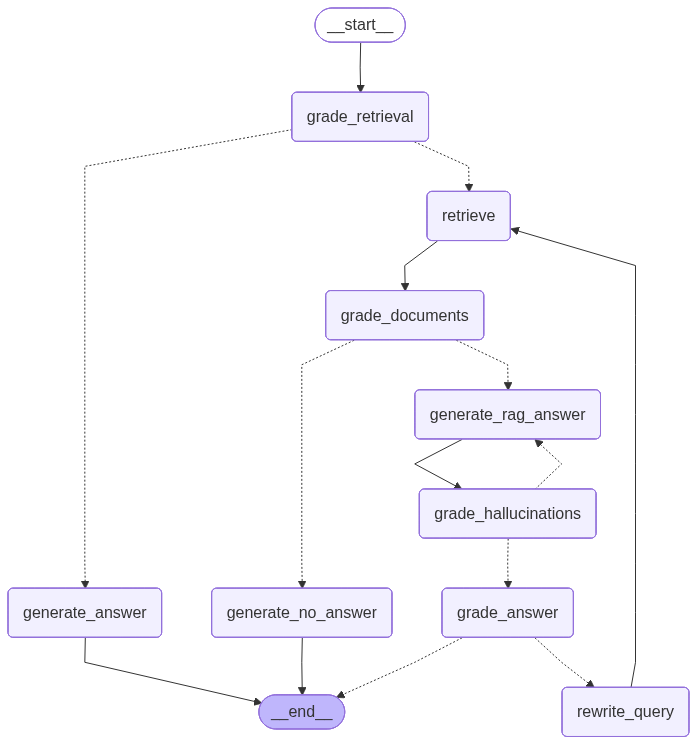

In [20]:
graph_builder = StateGraph(State)

graph_builder.add_edge(START, "grade_retrieval")
graph_builder.add_node("grade_retrieval", grade_retrieval)
graph_builder.add_conditional_edges(
    "grade_retrieval", 
    decide_to_retrieve,
    ["retrieve", "generate_answer"]
)

graph_builder.add_node("generate_answer", generate_answer)
graph_builder.add_edge("generate_answer", END)

graph_builder.add_node("retrieve", retrieve)
graph_builder.add_edge("retrieve", "grade_documents")
graph_builder.add_node("grade_documents", grade_documents)
graph_builder.add_conditional_edges(
    "grade_documents", 
    check_documents_relevance,
    ["generate_rag_answer", "generate_no_answer"]
)

graph_builder.add_node("generate_rag_answer", generate_rag_answer)
graph_builder.add_edge("generate_rag_answer", "grade_hallucinations")
graph_builder.add_node("grade_hallucinations", grade_hallucinations)
graph_builder.add_conditional_edges(
    "grade_hallucinations", 
    check_hallucinations,
    ["grade_answer", "generate_rag_answer"]
)

graph_builder.add_node("generate_no_answer", generate_no_answer)
graph_builder.add_edge("generate_no_answer", END)

graph_builder.add_node("grade_answer", grade_answer)
graph_builder.add_conditional_edges(
    "grade_answer", 
    check_answer,
    ["__end__", "rewrite_query"]
)

graph_builder.add_node("rewrite_query", rewrite_query)
graph_builder.add_edge("rewrite_query", "retrieve")

graph = graph_builder.compile()
graph

In [21]:
query = "What are common types of agent memory?"

response = graph.invoke({"question": query})
rprint(response)
rprint(Markdown(response["answer"]))

{
    'question': 'What are common types of agent memory?',
    'retrieval_grade': RetrievalGrade(
        chain_of_thought='Common types of agent memory include: – Long Short-Term Memory (LSTM): Good for 
remembering complex sequences and contextual information. – Transformer Memory:  Leverages self-attention 
mechanisms to capture long-range dependencies. – Neural Turing Machines: Allows for explicit control over memory 
updates. – Retrieval-Augmented Generation (RAG): Combines retrieval with generative models.',
        is_required=True
    ),
    'documents': [
        Document(
            id='e76443d4-aacd-44e0-a169-1053740a1671',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='Comparison of AD, ED, source policy and RL^2 on environments that require memory and 
exploration. Only binary reward is assigned. The source policies are trained with A3C for "dark" environments and 
DQN for watermaze.(Image source: Laskin et al. 2023)\n\nComponent Two: Memory#\n(Big thank you to ChatGPT for 
helping me draft this section. I’ve learned a lot about the human brain and data structure for fast MIPS in my 
conversations with ChatGPT.)\nTypes of Memory#\nMemory can be defined as the processes used to acquire, store, 
retain, and later retrieve information. There are several types of memory in human brains.\n\n\nSensory Memory: 
This is the earliest stage of memory, providing the ability to retain impressions of sensory information (visual, 
auditory, etc) after the original stimuli have ended. Sensory memory typically only lasts for up to a few seconds. 
Subcategories include iconic memory (visual), echoic memory (auditory), and haptic memory (touch).'
        ),
        Document(
            id='90751708-0118-4d4a-8557-775a9ada685d',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='Sensory memory as learning embedding representations for raw inputs, including text, 
image or other modalities;\nShort-term memory as in-context learning. It is short and finite, as it is restricted 
by the finite context window length of Transformer.\nLong-term memory as the external vector store that the agent 
can attend to at query time, accessible via fast retrieval.\n\nMaximum Inner Product Search (MIPS)#\nThe external 
memory can alleviate the restriction of finite attention span.  A standard practice is to save the embedding 
representation of information into a vector store database that can support fast maximum inner-product search 
(MIPS). To optimize the retrieval speed, the common choice is the approximate nearest neighbors (ANN)\u200b 
algorithm to return approximately top k nearest neighbors to trade off a little accuracy lost for a huge 
speedup.\nA couple common choices of ANN algorithms for fast MIPS:'
        ),
        Document(
            id='0491f251-483d-48f4-ba46-286d9e3cacb6',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='Memory stream: is a long-term memory module (external database) that records a 
comprehensive list of agents’ experience in natural language.\n\nEach element is an observation, an event directly 
provided by the agent.\n- Inter-agent communication can trigger new natural language statements.\n\n\nRetrieval 
model: surfaces the context to inform the agent’s behavior, according to relevance, recency and 
importance.\n\nRecency: recent events have higher scores\nImportance: distinguish mundane from core memories. Ask 
LM directly.\nRelevance: based on how related it is to the current situation / query.\n\n\nReflection mechanism: 
synthesizes memories into higher level inferences over time and guides the agent’s future behavior. They are 
higher-level summaries of past events (<- note that this is a bit different from self-reflection above)'
        ),
        Document(
            id='6e0a3fb2-6ff1-4136-a520-bde1b3bf

According to the provided text, common types of agent memory include:                                              

 • Sensory Memory: Retains impressions of sensory information.                                                     
 • Short-term Memory: Limited context window, suitable for in-context learning.                                    
 • Long-term Memory: Stores information for long-term access and retrieval.                                        
 • Maximum Inner Product Search (MIPS): External memory to alleviate the constraint of finite attention span, using
   approximate nearest neighbor search.